# EJERCICIOS

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, Normalization

In [9]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


I0000 00:00:1739464354.195583   19651 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739464354.223509   19651 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739464354.223708   19651 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## EJERCICIO 1

¿Cuántas neuronas hacen falta en la capa de salida para clasificar emails entre correo no deseado y correo deseado? 

¿Qué función de activación deberías usar en la capa de salida? 

Si, en cambio, quieres enfrentarte a MNIST, ¿cuántas neuronas necesitas en la capa de salida y qué función de activación deberías usar? 

¿Y si quieres que la red prediga los precios de la vivienda en California?

In [3]:
# 1 porque la salida es binaria 
# Sigmoide en la capa de salida
# Si es multiclase necesitariamo tantas neuronas como clases y softmax en la capa de salida
# Al ser regresion necesitamos una neurona y al ser un problema de regresion no solemos usar activacion en la capa de salida

## EJERCICIO 2

Entrena un red neuronal profunda con el conjunto de datos MNIST (puedes cargarlo con tf. keras. datasets.minst.load_data()). Intenta conseguir la mejor pruebas en el conjunto de validación  ajustando los hiperparámetros de modo manual. Prueba a buscar una buena tasa de aprendizaje y utiliza la detención temprana (mínimo hay que conseguir un 97%).

Pasos a seguir: 
+ Entrena varios modelos con distintas tasas de aprendizaje
+ Guarda cada modelo en un fichero
+ Carga cada modelo y evalúalo en el conjunto de cargas y quedate con programación con el mejor (bucle que se quede con el mejor), mostrando la tasa de aprendizaje y la exactitud del mejor modelo.

Si no obtienes más de un 97% vuelve a empezar.

In [10]:
df_mnist=tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
(x_train, y_train), (x_test, y_test) = df_mnist

# Normalizar los datos 
#x_train = x_train / 255.0
#x_test = x_test / 255.0


# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_temp, y_train, y_temp = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Dividir el conjunto temporal en validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
# Función para crear el modelo
def create_model(learning_rate, normalization_layer):
    model = Sequential([
        normalization_layer,  
        Flatten(input_shape=(28, 28)),
        Dense(300, activation="relu"),
        Dense(200, activation="relu"),
        Dense(10, activation="softmax")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Configurar el callback de detención temprana
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Lista de tasas de aprendizaje para probar
learning_rates = [0.01, 0.001, 0.0001]

# Variables para almacenar el mejor modelo
best_model_path = None
best_accuracy = 0
best_learning_rate = None

# Normalizar las imágenes dividiéndolas entre 255
X_train_normalized = X_train / 255.0
X_val_normalized = X_val / 255.0
X_test_normalized = X_test / 255.0

# Crear la capa de normalización
normalization_layer = Normalization()

# Adaptar la capa de normalización a los datos de entrenamiento
normalization_layer.adapt(X_train_normalized)

# Probar diferentes tasas de aprendizaje
for lr in learning_rates:
    print(f"Entrenando modelo con tasa de aprendizaje: {lr}")
    
    # Crear el modelo con la capa de normalización adaptada
    model = create_model(learning_rate=lr, normalization_layer=normalization_layer)
    
    model_path = f"Resultados/model_lr_{lr}.keras"

    history = model.fit(
        X_train_normalized, y_train,
        epochs=25,
        validation_data=(X_val_normalized, y_val),
        callbacks=[early_stopping],
    )

    # Guardar el modelo entrenado
    model.save(model_path)

    # Evaluar el modelo en el conjunto de prueba
    test_loss, test_accuracy = model.evaluate(X_test_normalized, y_test, verbose=0)
    print(f"Tasa de aprendizaje: {lr}, Precisión en prueba: {test_accuracy * 100:.2f}%")

    # Guardar el mejor modelo
    if test_accuracy > best_accuracy:
        best_model_path = model_path
        best_accuracy = test_accuracy
        best_learning_rate = lr

# Cargar y mostrar los resultados del mejor modelo
best_model = tf.keras.models.load_model(best_model_path)
best_test_loss, best_test_accuracy = best_model.evaluate(X_test_normalized, y_test, verbose=0)
print(f"\nMejor modelo:")
print(f"Tasa de aprendizaje: {best_learning_rate}")
print(f"Precisión en prueba: {best_test_accuracy * 100:.2f}%")


Entrenando modelo con tasa de aprendizaje: 0.01
Epoch 1/25


I0000 00:00:1739465221.581890   22322 service.cc:146] XLA service 0x765a600058a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739465221.581929   22322 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-02-13 17:47:01.594289: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-13 17:47:01.646368: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-02-13 17:47:02.413704: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_144', 36 bytes spill stores, 36 bytes spill loads

2025-02-13 17:47:02.706751: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memor

 221/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.7464 - loss: 1.0850

I0000 00:00:1739465223.466429   22322 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8602 - loss: 0.6467 - val_accuracy: 0.9370 - val_loss: 0.2833
Epoch 2/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.9288 - loss: 0.3086 - val_accuracy: 0.9382 - val_loss: 0.2680
Epoch 3/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.9379 - loss: 0.2668 - val_accuracy: 0.9403 - val_loss: 0.3069
Epoch 4/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.9474 - loss: 0.2336 - val_accuracy: 0.9413 - val_loss: 0.2424
Epoch 5/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.9501 - loss: 0.2187 - val_accuracy: 0.9507 - val_loss: 0.2593
Epoch 6/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.9574 - loss: 0.1866 - val_accuracy: 0.9427 - val_loss: 0.3197
Epoch 7/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step - accuracy: 0.9587 - loss: 0.1929 - val_accuracy: 0.9297 - val_loss: 0.4463
Epoch 8/25
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - accuracy: 0.9492 - loss: 0.2282

## EJERCICIO 3

Clasificación de Imágenes de Dígitos Escritos a Mano:

* Objetivo: Entrenar una red neuronal para clasificar imágenes de dígitos escritos a mano utilizando el conjunto de datos SVHN (Street View House Numbers).

* Tareas: 
    * Cargar el conjunto de datos, dividir los datos (train, valid y test), explorar los datos representando alguna imagen con su etiqueta y muestra los valores (únicos) de y (en el entrenamiento, en validación y en pruebas), preparar los datos (d normalizar dividiendo entre 255.0 e igual hay que hacer algo más), construir, compilar y entrenar una red neuronal. 

    * Utilizar detección temprana

    * Hacer una gráfica de como evoluciona accuracy y val_accuracy durante el entrenamiento

    * Si es necesario ajustar el modelo para lograr una mayor precisión.

    * Evalúar el modelo en el conjunto de test y hacer alguna predicción (representa alguna imagen con su etiqueta real y la predicha)

In [11]:
def load_svhn_data(url):
    path = tf.keras.utils.get_file("svhn.mat", url)
    data = loadmat(path)
    return np.transpose(data["X"], (3, 0, 1, 2)), data["y"].flatten()

# Cargar datos
train_url = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
test_url = "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
X_train_full, y_train_full = load_svhn_data(train_url)
X_test, y_test = load_svhn_data(test_url)
X_test2, y_test2 = load_svhn_data(test_url)

182040794/182040794 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


In [12]:
# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Normalizar etiquetas de clase: 10 -> 0
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0
y_val[y_val == 10] = 0

Forma de X_train: (58605, 32, 32, 3)
Forma de y_train: (58605,)
Forma de y_test: (73257,)
Forma de y_val: (14652,)
Valores únicos en y_train: [0 1 2 3 4 5 6 7 8 9]


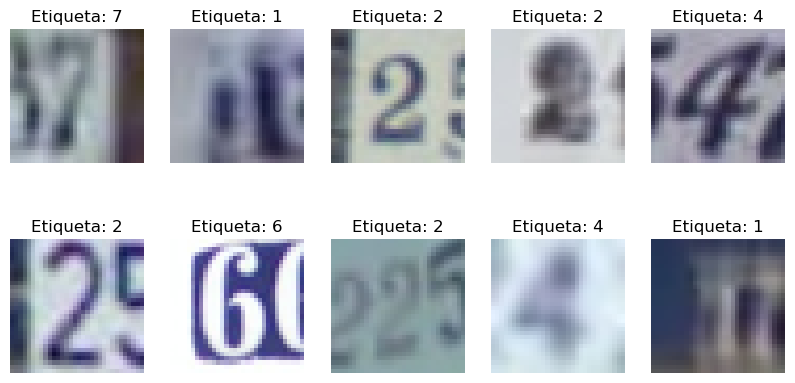

In [13]:
# Explorar los datos
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)
print("Forma de y_val:", y_val.shape)
print("Valores únicos en y_train:", np.unique(y_train))

# Visualizar algunas imágenes
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Etiqueta: {y_train[i]}")
    plt.axis('off')
plt.show()

In [16]:
# Preparar los datos
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


# Construir el modelo
model = Sequential([
        Input(shape=(32, 32, 3)),
        Flatten(),
        Dense(150, activation="relu"),
        Dense(300, activation="relu"),
        Dense(128, activation="relu"),
        Dense(10, activation="softmax")
    ])
# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Entrenar el modelo
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
        X_train, y_train,
        epochs=25,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
    )

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida en prueba: {loss}, Precisión en prueba: {accuracy}")

Epoch 1/25
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1858 - loss: 2.2378 - val_accuracy: 0.2501 - val_loss: 2.0744
Epoch 2/25
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 2s 953us/step - accuracy: 0.2463 - loss: 2.0595 - val_accuracy: 0.3150 - val_loss: 1.9035
Epoch 3/25
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 2s 923us/step - accuracy: 0.3244 - loss: 1.8562 - val_accuracy: 0.4245 - val_loss: 1.6585
Epoch 4/25
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 2s 938us/step - accuracy: 0.4413 - loss: 1.5834 - val_accuracy: 0.4996 - val_loss: 1.4485
Epoch 5/25
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step - accuracy: 0.4975 - loss: 1.4593 - val_accuracy: 0.5351 - val_loss: 1.3719
Epoch 6/25
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 2s 858us/step - accuracy: 0.5508 - loss: 1.3453 - val_accuracy: 0.5738 - val_loss: 1.2874
Epoch 7/25
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 2s 842us/step - accuracy: 0.5915 - loss: 1.2495 - val_accuracy: 0.5979 - val_loss: 1.2365
Epoch 8/25
1832/1832 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.6217 - l

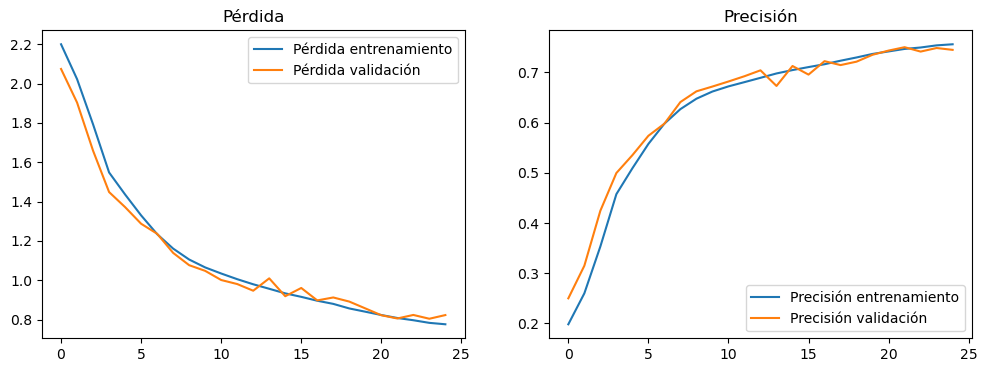

In [17]:
# Graficar el historial de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.legend()
plt.title('Pérdida')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.legend()
plt.title('Precisión')
plt.show()

2290/2290 ━━━━━━━━━━━━━━━━━━━━ 2s 854us/step


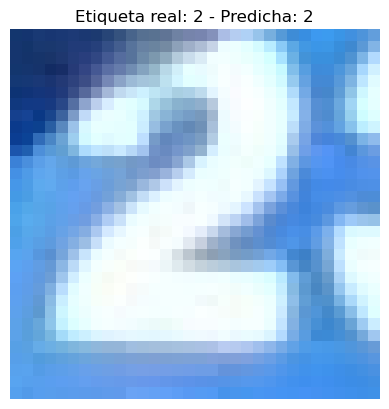

In [18]:
# Realizar una predicción y representar una imagen con etiqueta real y predicha
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Visualizar una imagen con su etiqueta real y predicha
index = 2  # Cambiar el índice para ver diferentes imágenes
plt.imshow(X_test2[index])
plt.title(f"Etiqueta real: {y_test[index]} - Predicha: {predicted_labels[index]}")
plt.axis('off')
plt.show()


## EJERCICIO 4

Predicción del consumo de energía:

* Objetivo: Construir una red neuronal para predecir el consumo de energía de edificios a partir de características como la temperatura, humedad, y tiempo del conjunto de datos Energy Efficiency de UCI Machine Learning Repository

* Tareas: 
    * Cargar el conjunto de datos, dividir los datos (train, valid y test), explorar los datos, preparar los datos (normalizar con una capa de normalización), construir un modelo de regresión, compilar y entrenar una red neuronal. 
    
    * Usa X1-X8 para la X e Y1-Y2 para la y

    * Ajusta el modelo hasta encontrar un error absoluto medio aceptable

    * Haz una gráfica de como evoluciona el error absoluto medio y error absoluto medio del conjunto de validación durante el entrenamiento

    * Evalúa el modelo en el conjunto de test y haz alguna predicción (muestra el valor predicho y el real)

In [20]:
# Descargar el conjunto de datos de eficiencia energética de UCI
url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx")
data = pd.read_excel(url)

In [21]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


In [23]:
X=data.drop(columns=["Y1", "Y2"]).to_numpy()
y=data[["Y1", "Y2"]].to_numpy()

# Dividir el conjunto de entrenamiento en entrenamiento y temporal
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Dividir el conjunto de entrenamiento en prueba y validación
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [24]:
# Construir el modelo

normalizer = Normalization()
normalizer.adapt(X_train)

model = Sequential([
        Input(shape=(X_train.shape[1],)),
        normalizer,
        Dense(150, activation="relu"),
        Dense(300, activation="relu"),
        Dense(128, activation="relu"),
        Dense(2)
    ])
# Compilar el modelo
model.compile(optimizer='adam',
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])


# Entrenar el modelo
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_absolute_error',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
        X_train, y_train,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
    )

Epoch 1/30
 2/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.9250 - mean_absolute_error: 23.9250

2025-01-16 01:07:54.621435: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_193', 12 bytes spill stores, 12 bytes spill loads

2025-01-16 01:07:55.365179: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_390', 20 bytes spill stores, 20 bytes spill loads

2025-01-16 01:07:55.386645: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_392', 12 bytes spill stores, 12 bytes spill loads

2025-01-16 01:07:55.523958: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_392', 12 bytes spill stores, 12 bytes spill loads

2025-01-16 01:07:55.555977: I external/local_xla/xla/stream_exec

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - loss: 22.0839 - mean_absolute_error: 22.0839 - val_loss: 16.0323 - val_mean_absolute_error: 16.0323
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.8111 - mean_absolute_error: 12.8111 - val_loss: 5.4811 - val_mean_absolute_error: 5.4811
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2128 - mean_absolute_error: 5.2128 - val_loss: 4.2540 - val_mean_absolute_error: 4.2540
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2645 - mean_absolute_error: 4.2645 - val_loss: 3.6824 - val_mean_absolute_error: 3.6824
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7318 - mean_absolute_error: 3.7318 - val_loss: 3.4574 - val_mean_absolute_error: 3.4574
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0728 - mean_absolute_error: 3.0728 - val_loss: 3.0729 - val_mean_absolute_error: 3.0729
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0955 - mean_absolute_error: 3.0955 - val_loss: 2.7217 -

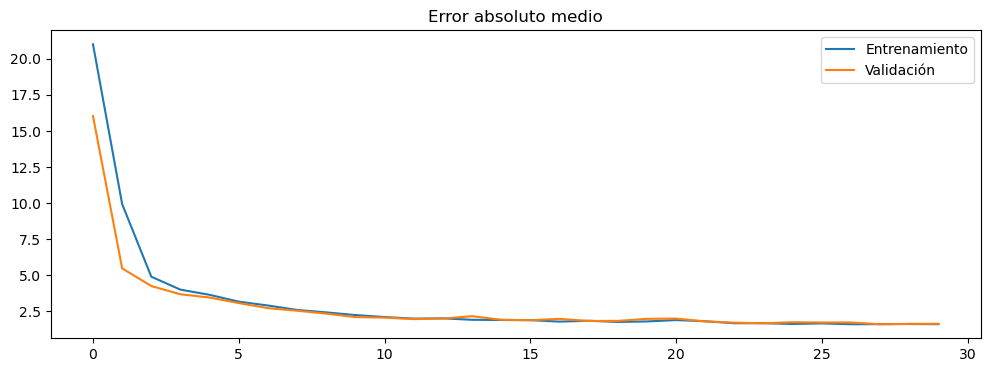

In [25]:
# Graficar el historial de entrenamiento
plt.figure(figsize=(12, 4))
plt.plot(history.history['mean_absolute_error'], label='Entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Validación')
plt.legend()
plt.title('Error absoluto medio')
plt.show()

In [26]:
# Evaluar el modelo
loss, mean_absolute_error = model.evaluate(X_test, y_test)
print(f"Error absoluto medio en prueba: {mean_absolute_error}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 515ms/step - loss: 1.7354 - mean_absolute_error: 1.7354
Error absoluto medio en prueba: 1.8154903650283813


In [27]:
# Predicciones finales
predictions = model.predict(X_test[:5])  # Predicción de las primeras 5 muestras
print("\nPredicciones (Y1, Y2) vs Reales (Y1, Y2):")
for i in range(5):
    print(f"Predicho: {predictions[i]}, Real: {y_test[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Predicciones (Y1, Y2) vs Reales (Y1, Y2):
Predicho: [30.4551   31.323738], Real: [23.67 24.8 ]
Predicho: [32.38998  33.385254], Real: [32.68 36.12]
Predicho: [33.75424 34.40931], Real: [26.84 30.17]
Predicho: [33.937626 34.921772], Real: [33.08 34.11]
Predicho: [14.830322 17.69708 ], Real: [14.66 17.74]
